# INTRODUCTION TO CUSTOM ASSESSMENT ANALYSIS

In Bonsai projects, logs are queried from Azure for two main reasons:
1. Ability to run whichever KPI metric was agreed with Subject Matter Experts. We want to convey training progress throughout experiments in the units the SMEs care about.
2. Transforming the custom assessment logs into graphs that are useful to guide conversations with the Subject Matter Experts.

There are two resources already available for you to check:
1. Query Custom Assessment Data - From DOCS
    - https://docs.microsoft.com/en-us/bonsai/cookbook/assessment/query-data
    - This doc contains the most updated step-by-step guide on the process.
2. Querying and Analyzing Logs from Project Bonsai - Jupyter NB
    - https://github.com/microsoft/bonsai-log-tools
    - This repo is the main resource that is refer to from the doc above. Feel free to click here if you already understand the main pipeline.

# 1. GETTING STARTED

This jupyter notebook focuses on the analysis of the custom assessments. In order to add your custom assessments for analysis, you will need to run the extraction analysis first, which should be named: "JNB_Custom_Assessment_Extraction".

*By having 2 independent notebooks, we remove the need to re-extract and re-format the KQL logs when driving conversations with Subject Matter Experts.* 

## 1.1. Select Datasets for Analysis

Once you have all the custom assessments of interest in your 'kql_logs' folder, you are good to select the ones desired for analysis.

In [1]:
import os
import datetime

# Define input folder to read logs from.
out_csv_subfolder = "kql_logs"
out_csv_folder = os.path.join(os.getcwd(), out_csv_subfolder)

if not os.path.exists(out_csv_folder):
    raise Exception(f"Folder with logs to be read not found: {out_csv_folder}")


# Retrieve all custom assessments that do not start with a timestamp.
custom_assessment_tag = "CustomAssess"
assess_list = [f for f in os.listdir(out_csv_folder) if f.startswith(custom_assessment_tag)]

print("Following assessments are available for extraction:\n")
print("\n".join(assess_list))

Following assessments are available for extraction:

CustomAssess_gym_brain_0803.csv
CustomAssess_modular_brain_0803.csv
CustomAssess_monolithic_brain_0803.csv


In [2]:
# - [Reusing TODO]: Select the assessments to compare from the available CSVs printed on the previous section.
selected_assessments = ["CustomAssess_gym_brain_0803",
                        "CustomAssess_monolithic_brain_0803",
                        "CustomAssess_modular_brain_0803"]


print("Following assessments have been selected for extraction:\n")
print("\n".join(selected_assessments))

Following assessments have been selected for extraction:

CustomAssess_gym_brain_0803
CustomAssess_monolithic_brain_0803
CustomAssess_modular_brain_0803


## 1.2. Extract the Assessments

**Note, if you want to compare several assessment policies, select a name for each assessment you want to query in the 'Optional' section 1.3.1.**

Running this cell reads the CSV files sected and adds corresponding entries to the comparison dictionary.

In [3]:
import pandas as pd
import numpy as np
import copy

# Initialize comparison dict for assessment.
comparison_df_dict = {}

for sel_assess in selected_assessments:
    # Automatically add the '.csv' tag if not provided
    if not sel_assess.endswith(".csv"):
        sel_assess = sel_assess + ".csv"
    
    # Get full filepath and read CSV into DataFrame
    assess_csv = os.path.join(out_csv_folder, sel_assess)
    assess_df = pd.read_csv(assess_csv)
    
    # Get assessment tag stored within custom assessment.
    assessment_tag = assess_df["custom_assessment_tag"].unique()[0]
    
    # Store in dictionary assessment DataFrame, indexed by tag.
    comparison_df_dict[assessment_tag] = assess_df
    
    # Print extracted DF.
    print(f"Extracted assessment '{sel_assess}'. Assessment tag is: '{assessment_tag}'.")


# Extract available datasets from comparison dict.
comparison_keys = list(comparison_df_dict.keys())

print(f"\n\nThe comparison dictionary contains the following custom assessment records:\n ---> {comparison_keys}")

Extracted assessment 'CustomAssess_gym_brain_0803.csv'. Assessment tag is: 'gym_brain'.
Extracted assessment 'CustomAssess_monolithic_brain_0803.csv'. Assessment tag is: 'monolithic_brain'.
Extracted assessment 'CustomAssess_modular_brain_0803.csv'. Assessment tag is: 'modular_brain'.


The comparison dictionary contains the following custom assessment records:
 ---> ['gym_brain', 'monolithic_brain', 'modular_brain']


# 2. ASSESSMENT EVALUATION

In this section, we will run KPI metrics over the retrieved custom assessment. Usually, you want to have a unique metric of success. Along that metric, you might have additional hard-requirments that must be satisfied.

## 2.1. DEFINE KPI METRICS OF INTEREST

To inform Subject Matter Experts about progress under the terms defined above, we will extract the following metrics:
- Sum distance to landing pad,
- Ship crash flag,
- Number of iterations per episode,
- Total fuel consumed.


**Main Indicator of Progress:**
- Aggregated (SUM) distance to landing pad, which is located at (0,0)

**2 Hard Requirements for Success:**
- AVOID crash,
- AVOID running out of fuel (limit of 180 across the episode).


In [4]:
# DEFINE YOUR KPI METHODS USING THE PANDAS DATAFRAME.
# - [Reusing TODO]: Modify this to your KPI metrics of interest -
def kpi_computation(df):
    # Append all metrics to this dictionary
    kpi_metrics_df = pd.DataFrame()
    
    # COMPUTE AGGREGATED SUM DISTANCE TO LANDING PAD
    # Compute squared error.
    df["distance_to_land_pad"] = np.sqrt(df['state_x_position']**2 + df['state_y_position']**2)
    pos_rms_error = df.groupby('EpisodeIndex')["distance_to_land_pad"].sum()
    kpi_metrics_df = kpi_metrics_df.append(pos_rms_error)
    
    # COMPUTE SHIP CRASH, using gym reward.
    df["ship_crash"] = df['state_gym_reward'].apply(lambda x: 1 if x < -90 else 0)
    episodes_crashed = df.groupby('EpisodeIndex')["ship_crash"].max()
    kpi_metrics_df = kpi_metrics_df.append(episodes_crashed)
    
    # NUMBER OF ITERATIONS.
    df["n_of_iterations"] = df['IterationIndex']
    episode_length = df.groupby('EpisodeIndex')['n_of_iterations'].max().apply(lambda x: x-1)
    kpi_metrics_df = kpi_metrics_df.append(episode_length)
    
    # COMBUSTION COSTS. Lateral engines have 10 times less power than main thrust (applies to engine2).
    df["fuel_consumed"] = df['action_engine1'].apply(lambda x: np.abs(x)) + \
                          0.1 * df['action_engine2'].apply(lambda x: np.abs(x))
    fuel_consumed = df.groupby('EpisodeIndex')['fuel_consumed'].sum()
    kpi_metrics_df = kpi_metrics_df.append(fuel_consumed)
    
    # APPEND SUCCESS METRIC BASED ON INDEPENDENT FUNCTIONALITY BELLOW
    # - We also transpose the DF to have KPIs as columns, not as labels -
    kpi_metrics_df = filter_passing_episodes(kpi_metrics_df.T)
    
    return kpi_metrics_df


# DEFINE COLOURING FOR HARD REQUIREMENTS
# - [Reusing TODO]: Modify this to your success criteria -
def filter_passing_episodes(kpi_df):
    # No episode can result in crash,
    # No episode should have a fuel consumption higher than 180.
    
    df_crash_filter = kpi_df["ship_crash"] < 1
    df_consumption_filter = kpi_df["fuel_consumed"] < 180
    
    df_pass_filter = df_crash_filter & df_consumption_filter
    kpi_df["Episode Result"] = df_pass_filter.apply(lambda x: "Success" if x else "Fail")
    
    return kpi_df

## 2.2. KPI DISTRIBUTION ANALYSIS

To be able to understand better our results, it is better to look at distributions. Let's plot the success metrics aggregated across our custom assessment of interest.

*Note, if you instanced the 'comparison_df_dict' dictionary, you will be able to see the aggregated comparison across assessments.*

### 2.2.1. Overall Success & Progress

In [5]:
# (1) AGGREGATE MEAN & STD DEV FOR MAIN KPI METRIC
# - [Reusing TODO]: Modify this to your column of interest -
kpi_column = 'distance_to_land_pad'

# Auxiliary aggregation table
aggregated_kpi_df = pd.DataFrame(index=[kpi_column+" (mean)", kpi_column+" (std)"])
for assess_name, assess_df in comparison_df_dict.items():
    # Extract KPI df.
    assess_kpi_df = kpi_computation(assess_df)
    # Compute Mean & Std Dev.
    kpi_mean = int(np.mean(assess_kpi_df[kpi_column]))
    kpi_std = int(np.std(assess_kpi_df[kpi_column]))
    # Append values to auxiliary DataFrame.
    aggregated_kpi_df[assess_name] = [kpi_mean, kpi_std]


# (2) AGGREGATE SUCCESS COUNT & TOT NUM OF EPISODES
# Target column to plot. This is hard coded based on 'filter_passing_episodes' method above.
result_column = 'Episode Result'

# Auxiliary aggregation table
aggregated_success_df = pd.DataFrame(index=["Episode Count", "Successful Episodes (%)"])
for assess_name, assess_df in comparison_df_dict.items():
    # Extract KPI df.
    assess_kpi_df = kpi_computation(assess_df)
    # Compute Number of Successes against Number of Episodes.
    success_count = int(assess_kpi_df[result_column].apply(lambda x: x == "Success").sum())
    episode_count = int(len(assess_kpi_df))
    success_perc = int(success_count/episode_count * 100)
    # Append values to auxiliary DataFrame.
    aggregated_success_df[assess_name] = [episode_count, str(success_perc) + "%"]

# Fix to resolve a missing column when all episodes are success or fail.
aggregated_success_df = aggregated_success_df.fillna(0)


# (3) AGGREGATE & PLOT TABLE WITH ALL AGGREGATED METRICS
aggregated_success_df = aggregated_success_df.append(aggregated_kpi_df)

aggregated_success_df

,gym_brain,monolithic_brain,modular_brain
Episode Count,30,30,30
Successful Episodes (%),70%,0%,93%
distance_to_land_pad (mean),111,107,96
distance_to_land_pad (std),37,29,32


### 2.2.2. In-depth Success Metrics

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# TARGET COLUMN TO PLOT 1
# - [Reusing TODO]: Modify these to your column of interest, and threshold values -
success_column_1 = 'ship_crash'
success_threshold_1 = 0.5

# TARGET COLUMN TO PLOT 2
# - [Reusing TODO]: Modify these to your column of interest, and threshold values -
success_column_2 = 'fuel_consumed'
success_threshold_2 = 180

# PLOT DISTRIBUTION FOR EACH ASSESSMENT STORED (both count & density histograms)
summary_success_df = pd.DataFrame(index=["Episode Count",
                                         success_column_1+": # of fails",
                                         success_column_2+": # of fails"])
for assess_name, assess_df in comparison_df_dict.items():
    # Extract KPI df.
    assess_kpi_df = kpi_computation(assess_df)
    # Compute Number of Episodes.
    episode_count = int(len(assess_kpi_df))
    # Compute Number of Successes for hard requirement 1.
    success_count_1 = int(assess_kpi_df[success_column_1].apply(lambda x: x > success_threshold_1).sum())
    # Compute Number of Successes for hard requirement 2.
    success_count_2 = int(assess_kpi_df[success_column_2].apply(lambda x: x > success_threshold_2).sum())
    summary_success_df[assess_name] = [episode_count, success_count_1, success_count_2]

summary_success_df

,gym_brain,monolithic_brain,modular_brain
Episode Count,30,30,30
ship_crash: # of fails,2,1,2
fuel_consumed: # of fails,7,29,0


### 2.2.3. Success Requirement 2: Fuel Consumption Analysis

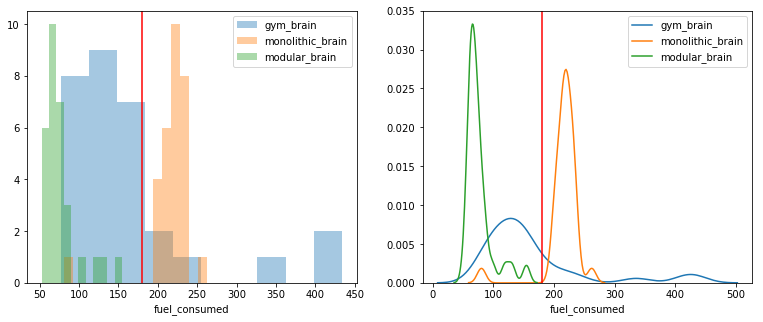

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Target column to plot
# - [Reusing TODO]: Modify this to your column of interest -
kpi_column = 'fuel_consumed'
# - [Reusing TODO]: Modify hard coded value, or remove if not applicable -
kpi_threshold = 180

# PLOT DISTRIBUTION FOR EACH ASSESSMENT STORED (both count & density histograms)
f, ax = plt.subplots(1, 2, figsize=(13,5))
summary_fuel_df = pd.DataFrame(index=[kpi_column+": success"])
for assess_name, assess_df in comparison_df_dict.items():
    # Extract KPI df.
    assess_kpi_df = kpi_computation(assess_df)
    # Compute Number of Successes for current hard requirement.
    success_count = int(assess_kpi_df[kpi_column].apply(lambda x: x < kpi_threshold).sum())
    summary_fuel_df[assess_name] = success_count
    # Plot both a count-based histogram, as well as a gaussian distribution representation.
    sns.distplot(assess_kpi_df[kpi_column], axlabel=kpi_column, hist=True, kde=False, label=assess_name, ax=ax[0])
    sns.distplot(assess_kpi_df[kpi_column], axlabel=kpi_column, hist=False, kde=True, label=assess_name, ax=ax[1])

# Plot a line indicating success for fuel_consumed
ax[0].axvline(kpi_threshold, color='red')
ax[1].axvline(kpi_threshold, color='red')

# Plot legends for both plots
ax[0].legend()
ax[1].legend()


### 2.2.4. Continuous Progress Metric: Distance to Landing Pad Analysis

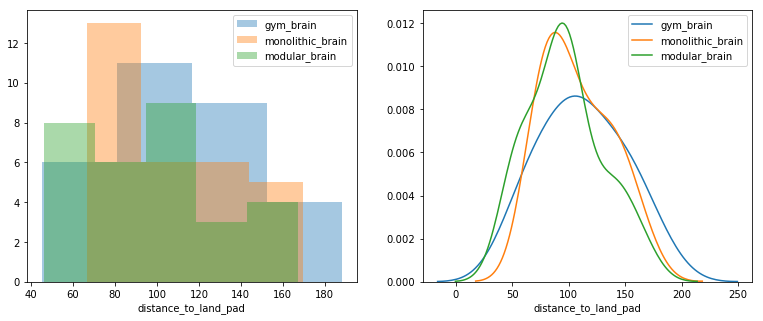

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Target column to plot
# - [Reusing TODO]: Modify this to your column of interest -
kpi_column = 'distance_to_land_pad'

f, ax = plt.subplots(1, 2, figsize=(13,5))
for assess_name, assess_df in comparison_df_dict.items():
    # Extract KPI df.
    assess_kpi_df = kpi_computation(assess_df)
    # Plot both a count-based histogram, as well as a gaussian distribution representation.
    sns.distplot(assess_kpi_df[kpi_column], axlabel=kpi_column, hist=True, kde=False, label=assess_name, ax=ax[0])
    sns.distplot(assess_kpi_df[kpi_column], axlabel=kpi_column, hist=False, kde=True, label=assess_name, ax=ax[1])

# Plot legends for both plots
ax[0].legend()
ax[1].legend()

# 2.3. EPISODIC TRANSIT ANALYSIS

After looking at the high-level KPI performance of the brain across episodes, we now want to understand the states that are visited by the brain towards accomplishing its task. Identifying any gaps or unexpected behavior is key towards iterating to more stable controls.

### 2.3.1. Define States & Actions of Interest

In [9]:
# ANALYZE THE EVOLUTION OF POSITIONS AGGREGATEDLY
# - [Reusing TODO]: Modify this to your columns of interest -
target_states = ['state_x_position',
                 'state_y_position',
                 'state_x_velocity',
                 'state_y_velocity',
                 'state_angle',
                 'state_rotation',
                 'action_engine1',
                 'action_engine2']

### 2.3.2. Plot Episodic Transits

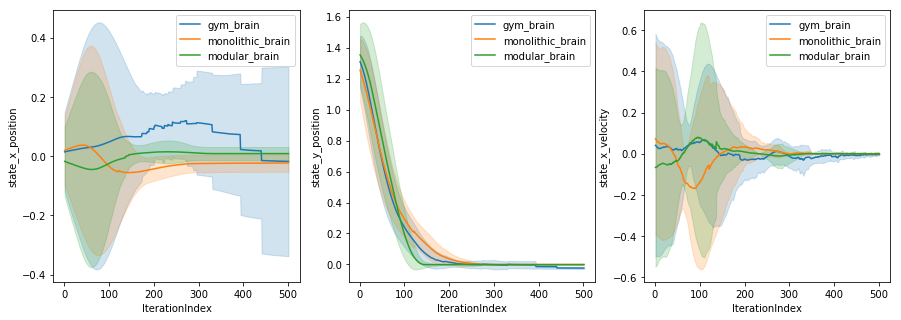

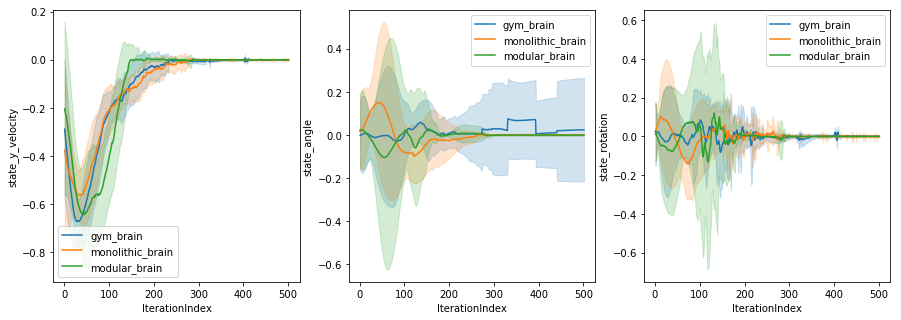

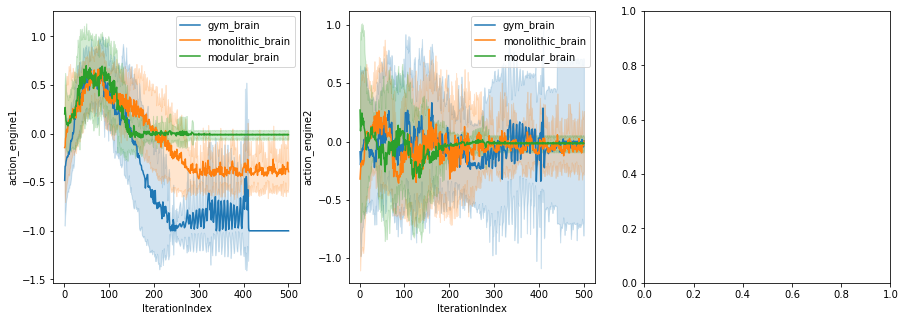

In [10]:
# (aux) Plotting auxiliary functionality
i_column = 0
n_columns = 3

# ITERATE OVER ALL STATES AND PLOT THEIR AGGREGATED DISTRIBUTION OVER TIME
for state_name in target_states:
    
    # (aux) Plotting auxiliary functionality
    if i_column == 0:
        fig, axes = plt.subplots(nrows=1, ncols=n_columns, figsize=(15,5))
    
    # PLOT THE EVOLUTION OF STATES ACROSS EPISODES
    for assess_name, assess_df in comparison_df_dict.items():
        sns.lineplot(data=assess_df, x="IterationIndex", y=state_name, ci="sd", ax=axes[i_column], label=assess_name)
    
    # (aux) Plotting auxiliary functionality
    if i_column < n_columns-1:
        i_column += 1
    else:
        i_column = 0
        plt.show()

plt.show()

## 2.4. Summary

Up to this point, we have performed the following operations:

- Define KPI Metrics of Interest.
- KPI Distribution Analysis.
- Episodic Transit Analysis.

# 3. FULL KPI METRICS PER EPISODE (Individual Dataset)

Plot the episodic performance for a specific dataset. Defaults to last read KQL dataset if no aggregation is performed.

## 3.1. Select a Dataset of your Choice

*Defaults to last dataset added to the comparison dictionary.*

In [11]:
# Optional TODO: Modify target_df_name to a specific key if you wish.
# - By default, we select the last added one
target_df_name = comparison_keys[-1]

# Extract the information.
target_df = comparison_df_dict[target_df_name]
n_episodes = len(target_df.groupby("EpisodeIndex"))
n_iterations = len(target_df)
print(f"Analytics will be provided for the last added dataset to 'comparison_df_dict':")
print(f"- Assessment name: '{target_df_name}'")
print(f"- Number of episodes: {n_episodes}")
print(f"- Number of iterations: {n_iterations}")
print(f"\nFeel free to enter manually (into 'target_df_name' var) a different dataframe from the following list:\n---> {comparison_keys}.")
    

Analytics will be provided for the last added dataset to 'comparison_df_dict':
- Assessment name: 'modular_brain'
- Number of episodes: 30
- Number of iterations: 14307

Feel free to enter manually (into 'target_df_name' var) a different dataframe from the following list:
---> ['gym_brain', 'monolithic_brain', 'modular_brain'].


## 3.2. Extract High-Level Information and Split Datasets

In [12]:
# Extract KPI metrics per episode.
kpi_df = kpi_computation(target_df)

# Split episodes into successful and failed based on the 'filter_passing_episodes' method.
success_filter = kpi_df["Episode Result"] == "Success"
successful_kpi_df = kpi_df[success_filter]
failed_kpi_df = kpi_df[~success_filter]

print(f"The assessment provided contains {len(kpi_df)} episodes:")
print(f"- We found {len(successful_kpi_df)} successful episodes.")
print(f"- We found {len(failed_kpi_df)} failed episodes.")

The assessment provided contains 30 episodes:
- We found 28 successful episodes.
- We found 2 failed episodes.


## 3.3. Retrieve Full Metrics for Successful Episodes

In [13]:
# Plot successful episodes
successful_kpi_df

,distance_to_land_pad,ship_crash,n_of_iterations,fuel_consumed,Episode Result
0,102.788474,0.0,500.0,62.688167,Success
1,50.661928,0.0,500.0,59.653574,Success
2,122.110544,0.0,500.0,75.481230,Success
3,93.963873,0.0,500.0,63.661844,Success
4,51.071626,0.0,500.0,59.220606,Success
5,79.423572,0.0,500.0,61.994134,Success
6,95.112918,0.0,500.0,67.058108,Success
7,97.469867,0.0,500.0,52.795276,Success
8,95.496577,0.0,500.0,63.568951,Success
9,110.578102,0.0,500.0,73.068330,Success


## 3.4. Retrieve Full Metrics for Failed Episodes

In [14]:
# Plot failed episodes
failed_kpi_df

,distance_to_land_pad,ship_crash,n_of_iterations,fuel_consumed,Episode Result
13,103.261001,1.0,135.0,78.796951,Fail
23,143.582319,1.0,142.0,73.543034,Fail


## 3.5. Summary

On this section, we have performed the following operations:

- Select dataset of our choice and print high-level success data.
- Print in-depth episodic results for both successful and failed episodes.

# 4. EXPLORE STATE & ACTION DISTRIBUTIONS (Individual Dataset)

This is specially useful for modular brains. You can easily understand where the model is behaving as expected, and where it might be failing to generalize correctly.

## 4.1. Select a Dataset of your Choice

*Defaults to last dataset added to the comparison dictionary.*

In [15]:
# Optional TODO: Modify target_df_name to a specific key if you wish.
# - By default, we select the last added one
target_df_name = comparison_keys[-1]

# Extract the information.
target_df = comparison_df_dict[target_df_name]
n_episodes = len(target_df.groupby("EpisodeIndex"))
n_iterations = len(target_df)
print(f"Analytics will be provided for the last added dataset to 'comparison_df_dict':")
print(f"- Assessment name: '{target_df_name}'")
print(f"- Number of episodes: {n_episodes}")
print(f"- Number of iterations: {n_iterations}")
print(f"\nFeel free to enter manually (into 'target_df_name' var) a different dataframe from the following list:\n---> {comparison_keys}.")
    

Analytics will be provided for the last added dataset to 'comparison_df_dict':
- Assessment name: 'modular_brain'
- Number of episodes: 30
- Number of iterations: 14307

Feel free to enter manually (into 'target_df_name' var) a different dataframe from the following list:
---> ['gym_brain', 'monolithic_brain', 'modular_brain'].


## 4.2. Select Target States and Remove NaNs (plus other transformations)

Other transformations include:
- Transform concept value into corresponding concept name.
- *Note, this is very specific to this problem, and you probably won't be able to reuse it for other simulation.*

*Remove the concept transformation to prevent the "KeyError" message.*

In [16]:
# PLOT RELATIONSHIPS BETWEEN CONCEPT AND POSITIONS
# - [Reusing TODO]: Modify this to your columns of interest -
target_states = ['action_engine1',
                 'action_engine2',
                 'state_x_position',
                 'state_y_position',
                 'state_x_velocity',
                 'state_y_velocity',
                 'state_angle',
                 'state_rotation']


# FILL NaNs WITH ZEROS.
# - In order to plot actions, we need to get rid of NaNs first.
action_cols = [col_name for col_name in target_df.columns if col_name.startswith("action")]
for column_name in action_cols:
    target_df[column_name] = target_df[column_name].fillna(0)

# TRANSFORM ACTION FROM NUMBER TO LABEL
# - [Reusing TODO]: Modify this to your custom transformation. Might not be applicable.
if "SelectedConcept" in target_df.columns:
    print("YOUR BRAIN CONTAINS A SELECTOR CONCEPT.")
    print("\nThe following concepts are available for you to use as color filters in the next section:")
    print("".join(["- " + c + "\n" for c in target_df["SelectedConcept"].unique()]))

YOUR BRAIN CONTAINS A SELECTOR CONCEPT.

The following concepts are available for you to use as color filters in the next section:
- TransfActionStop
- TransfActionRight
- TransfActionDown
- TransfActionUp
- TransfActionLeft



## 4.3. STATE-ACTION DISTRIBUTION: Down, Stop, & Up

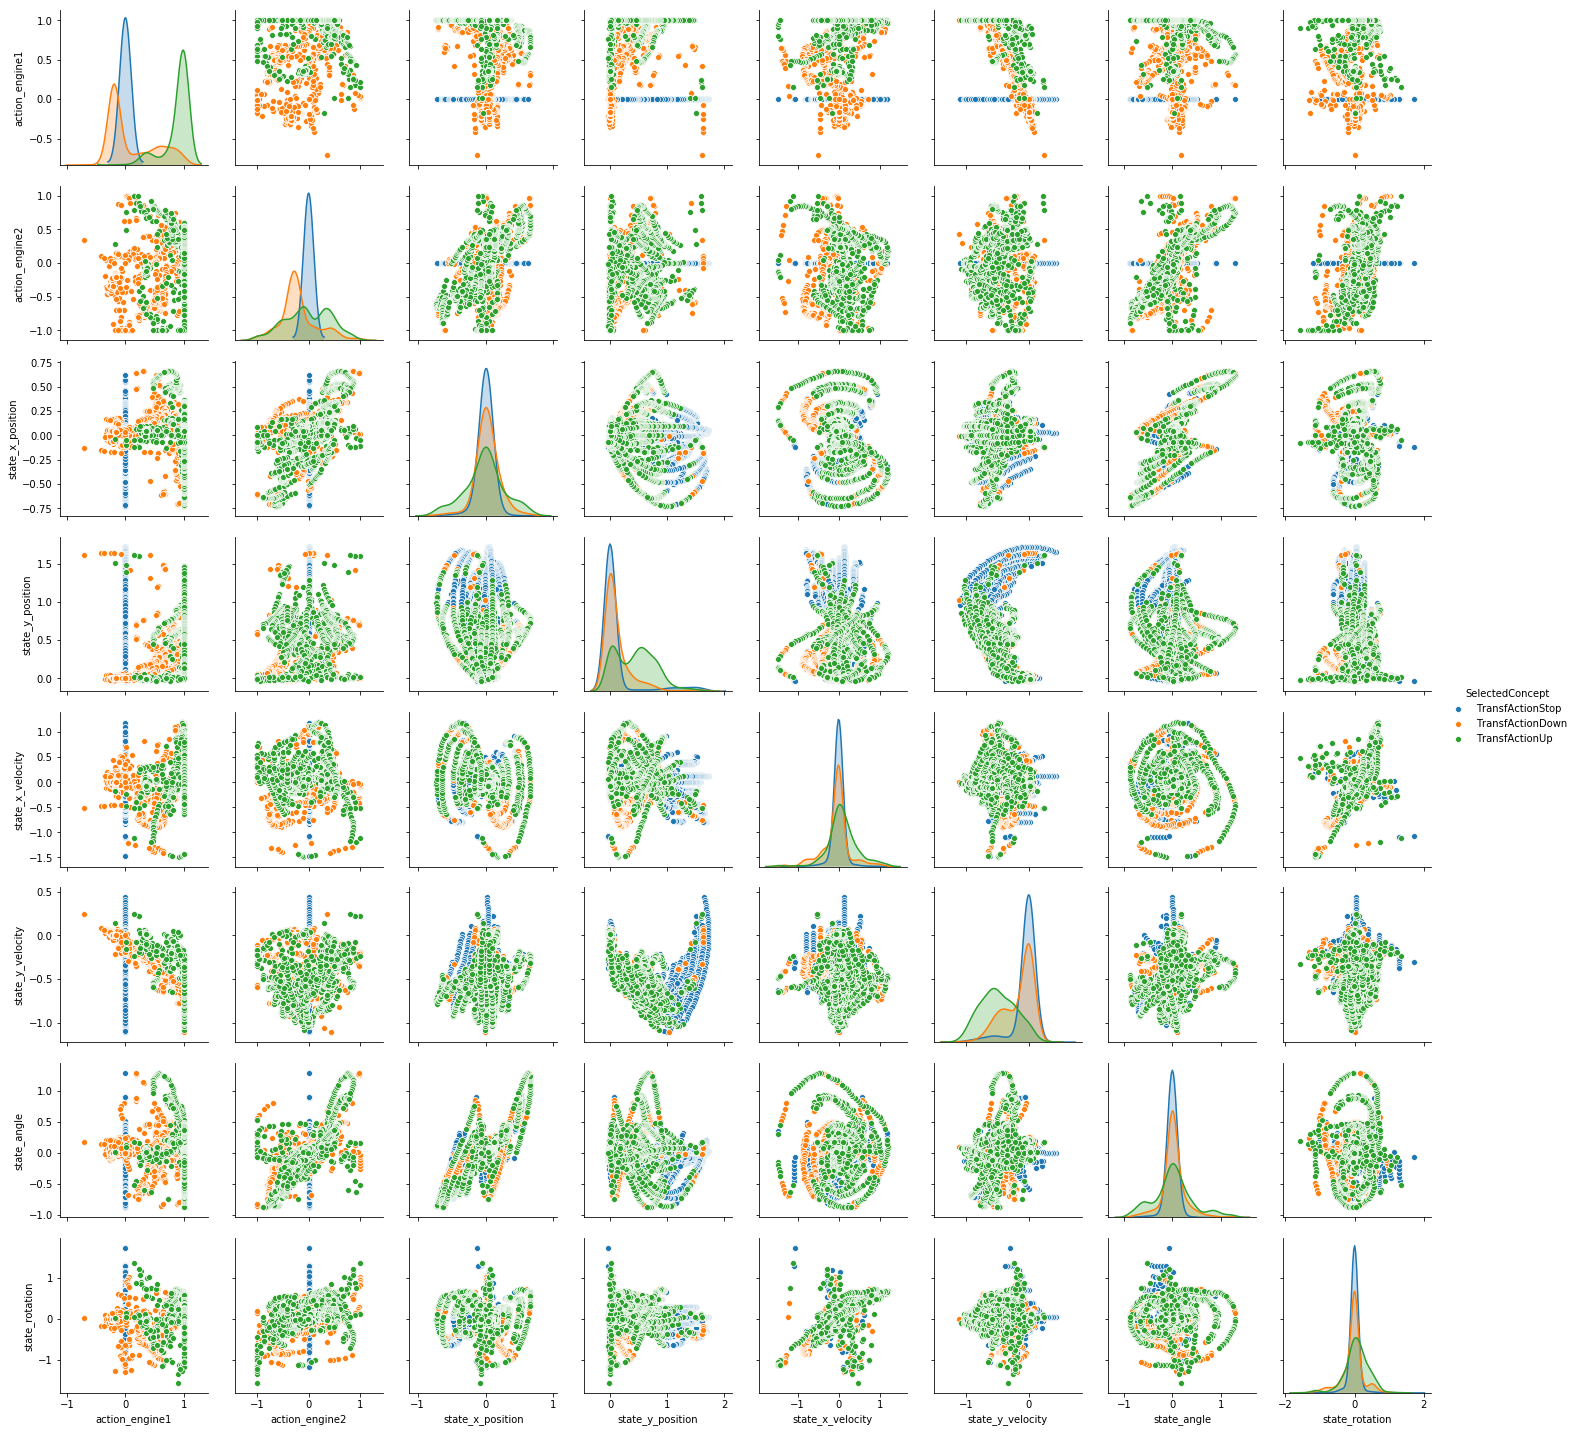

In [17]:
# Perform concept filtering if we are working with Lunar Lander modular brain.
# - [Reusing TODO]: Modify this to your custom filtering functions.
if "SelectedConcept" in target_df.columns:
    # Plot the relationship across variables.
    target_df_filter = target_df["SelectedConcept"] == "TransfActionDown"
    target_df_filter |= target_df["SelectedConcept"] == "TransfActionStop"
    target_df_filter |= target_df["SelectedConcept"] == "TransfActionUp"
    df_filtered = target_df[target_df_filter].copy()

    sns.pairplot(df_filtered, vars=target_states, kind='scatter', hue='SelectedConcept', diag_kws={'bw': .1})
    
# If we are working on a non-modular version of Lunar Lander, retrieve uncolored version.
else:
    sns.pairplot(target_df, vars=target_states, kind='scatter') #, diag_kws={'bw': .1})

## 4.4. STATE-ACTION DISTRIBUTION: Right & Left

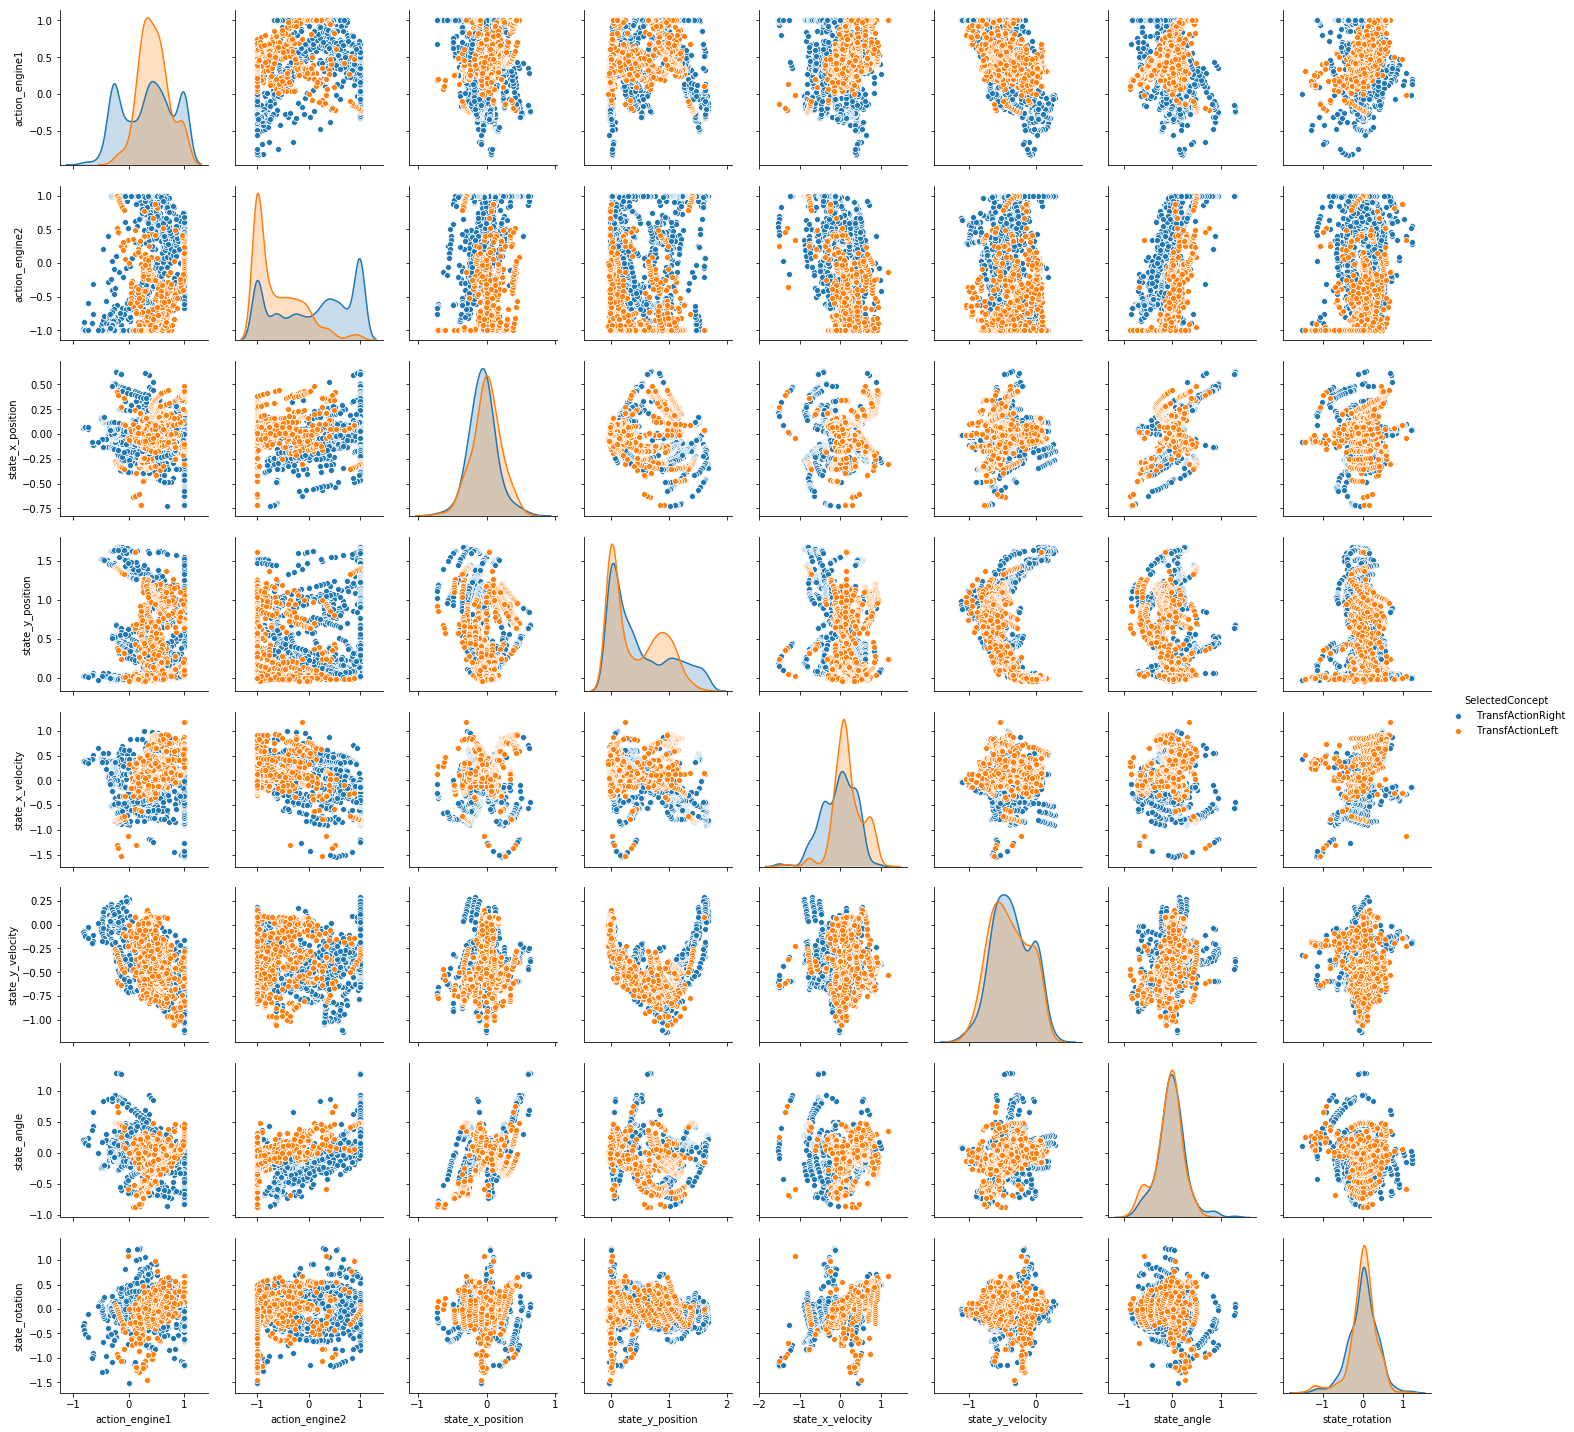

In [18]:
# Perform concept filtering if we are working with Lunar Lander modular brain.
# - [Reusing TODO]: Modify this to your custom filtering functions.
if "SelectedConcept" in target_df.columns:
    # Plot the relationship across variables.
    target_df_filter = target_df["SelectedConcept"] == "TransfActionRight"
    target_df_filter |= target_df["SelectedConcept"] == "TransfActionLeft"
    df_filtered = target_df[target_df_filter].copy()

    sns.pairplot(df_filtered, vars=target_states, kind='scatter', hue='SelectedConcept', diag_kws={'bw': .1})
    
# If we are working on a non-modular version of Lunar Lander, retrieve uncolored version.
else:
    sns.pairplot(target_df, vars=target_states, kind='scatter') #, diag_kws={'bw': .1})

## 4.5. Summary

On this section, we have performed the following operations:

- Define dataset of interest and columns to be plotted.
- Print the decomposition bivariate distribution of actions and states colored by selected action.

## (bonus) 4.6. 2D Distribution Plots

This plot computes the bivariate distributions for the filtered dataset above. It will only work on the df_filtered dataset.

Too much information becomes noise. Being able to understand what plots are the most relevant to your problem and customer (Subject Matter Experts) is the key to success on any Machine Teaching Experimentation process.

In [ ]:
g = sns.PairGrid(df_filtered, vars=target_states, hue='action_concept_name') #, diag_kws={'bw': 10})
g = g.map_diag(sns.kdeplot, lw=3, bw=0.1)
g = g.map_offdiag(sns.kdeplot, lw=1)

plt.show()